In [1]:
# ! pip install torch==2.5.1
# ! pip install pytorch-ignite==0.5.1

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Loss, Accuracy
from ignite.handlers.tqdm_logger import ProgressBar
from ignite.handlers import FastaiLRFinder

## Import i przygotowanie danych

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
folder = '' #zmodyfikuj ścieżkę odpowiednio do lokalizacji plików

feats = np.load(folder+'melspec_feats.npy')
labels = np.load(folder+'labels.npy')

In [5]:
feats = feats.reshape(feats.shape[0], -1)
feats = feats.astype(np.float32)

X_train, X_val_test, y_train, y_val_test = train_test_split(feats, labels, random_state=42, stratify=labels, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, random_state=42, stratify=y_val_test, train_size=0.5)

## DataLoader

In [6]:
trainset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
testset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(trainset, batch_size=256)
val_loader = DataLoader(valset, batch_size=256)
test_loader = DataLoader(testset, batch_size=256)

## Architektura sieci

Oprócz poprawnego procesu uczenia, kiedy sieć stopniowo uczy się wychwytywać zależności w danych, możemy mieć do czynienia z [dwiema niepożądanymi sytuacjami](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/):
* przeuczenie sieci (*overfitting*), czyli zbytnie dopasowanie do zbioru treningowego - model osiąga dobre wyniki na zbiorze treningowym, ale ma słabą zdolność do generalizacji.
* niedouczenie sieci (*underfitting*), kiedy model nie jest w stanie wychwycić zależności w danych i osiąga słabe wyniki. Może to znaczyć, że jego architektura jest niedostosowana do stopnia skomplikowania problemu, trening trwał zbyt krótko (za mało epok), lub wybrana reprezentacja danych jest zbyt prosta (np. zbyt mała rozdzielczość częstotliwościowa spektrogramu/szerokość filtra).

Do przeuczenia często dochodzi, kiedy zbiór uczący jest zbyt mały. Nie zawsze jesteśmy w stanie go powiększyć o nowe dane, ale możemy zastosować inne [techniki pozwalające zmniejszyć przeuczenie](https://www.pinecone.io/learn/regularization-in-neural-networks/):

* augmentacja danych, czyli sztuczne zwiększanie zbioru uczącego poprzez przekształcenia - np. obrót lub odbicie lustrzane, jeśli pracujemy na obrazach, czy dodanie szumu lub pogłosu w przypadku danych audio. Techniki augmentacji dodajemy do dataloadera;
![Przykład augmentacji obrazów](https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fb9e10cf4e0b69c92426fc686470e85008db934ac-1000x450.png&w=1080&q=75)
* *early-stopping*, czyli zakończenie treningu, kiedy funkcja kosztu osiąga minimum;
* regularyzacja, czyli modyfikacja funkcji kosztu w taki sposób, aby wprowadzić dodatkowe skalowanie współczynników, zwiększające wagę istotnych cech danych;
* ***dropout*** - polega on na losowym „wyłączaniu” neuronów podczas kolejnych iteracji (czyli ustawianiu ich wag na 0) oraz skalowaniu pozostałych przez współczynnik $1/(1-p)$, gdzie $p$ to zadany parametr *dropoutu*. Dzięki temu sieć nie może dopasować się idealnie do danych uczących, ponieważ podczas treningu musi dopasować wagi w taki sposób, by uzyskać dobre rezultaty również wtedy, gdy część neuronów będzie nieaktywna.

Definiując warstwę *dropout* określamy prawdopodobieństwo wyłączenia neuronów. Domyślnie $p=0,5$; można tę wartość zmienić, ale należy robić to w sposób przemyślany. Jeżeli ustawimy zbyt dużą wartość prawdopodobieństwa, to sieć może nie być w stanie w ogóle nauczyć się klasyfikować danych. Jeżeli ustawimy wartość zbyt małą, to regularyzacja może być nieefektywna i nie zmniejszymy przeuczenia sieci.

Dla utrzymania przejrzystości kodu, jak każdą warstwę, najlepiej jest zdefiniować *dropouty* w funkcji `__init__` i potem odnosić się do nich tworząc połączenia sieci w funkcji `forward`, np.:

```
def __init__(self):
    self.fc1 = nn.Linear(2574, 256)
    self.fc2 = nn.Linear(256, 120)
    self.fc3 = nn.Linear(120, 35)
    self.dropout1 = nn.Dropout(p=0.5)
    self.dropout2 = nn.Dropout(p=0.2)
    
def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
```

# Zadanie

Sprawdź, czy uda Ci się zmienić architekturę sieci tak, aby uzyskać lepsze wyniki.

Możesz to zrobić:
- zwiększając liczbę warstw (uwaga na liczbę wejść i wyjść każdej warstwy),
- dodając dropout,
- zmieniając funkcję aktywacji warstw (wszystkich lub niektórych),
- zmieniając optimizer.

Po zmianach zwróć uwagę, czy ustalona liczba epok wystarcza do nauczenia sieci - jeżeli do ostatniej epoki obserwujesz wzrost dokładności na zbiorze walidacyjnym, to prawdopodobnie sieć nadal nie jest w pełni nauczona i dłuższy trening przyniesie poprawę wyników. Jeżeli od pewnego momentu treningu obserwujesz spadek dokładności, to sieć zaczęła się przeuczać i trzeba zmniejszyć liczbę epok (uwaga: chodzi o trend spadkowy, a nie pojedyncze wahania).

In [7]:
class Net(nn.Module): # dziedziczenie po klasie nn.Module
    def __init__(self,
                 n_features, # liczba cech = pasm częstotliwości * ramek
                 hidden_in, # liczba neuronów wejściowych warstwy ukrytej
                 hidden_out, # liczba neuronów wyjściowych warstwy ukrytej
                 n_classes # liczba klas w zbiorze
                 ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_in)
        self.fc2 = nn.Linear(hidden_in, hidden_out)
        self.fc2_5 = nn.Linear(hidden_out, hidden_out)
        self.fc3 = nn.Linear(hidden_out, n_classes)
        self.do1 = nn.Dropout(0.3)
        self.do2 = nn.Dropout(0.5)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.do2(x)
        x = self.fc2_5(x)
        x = self.fc3(x)
        return self.softmax(x)

## Funkcja straty i optymalizator

In [8]:
criterion = nn.NLLLoss()

# tworzymy sieć podając argumenty funkcji init
model = Net(n_features=feats.shape[1], #liczba cech = pasm częstotliwości * ramek
            hidden_in=256,
            hidden_out=120, # liczba neuronów w warstwie pośredniej
            n_classes=35 # liczba klas w zbiorze
        )

device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)
model.to(device)  # Move model before creating optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)

In [9]:
init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

## Trainer i Evaluator

In [10]:
trainer = create_supervised_trainer(model,
                                    optimizer,
                                    criterion,
                                    device=device)

evaluator = create_supervised_evaluator(model,
                                        metrics={"acc": Accuracy(), "loss": Loss(nn.NLLLoss())},
                                        device=device)

ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})

c:\Users\mfox4\anaconda3\envs\pum\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Iteration: [33/33] 100%|██████████, batch loss=4.93 [00:00<00:00]
c:\Users\mfox4\anaconda3\envs\pum\lib\site-packages\ignite\handlers\lr_finder.py:201: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  warnings.warn(


Suggested LR 0.00024770763559917106


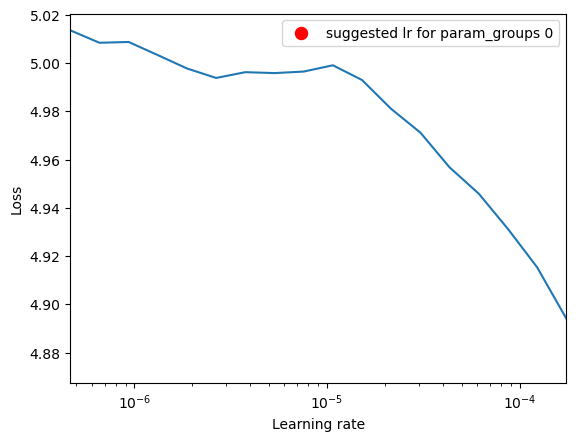

<Axes: xlabel='Learning rate', ylabel='Loss'>

In [11]:
lr_finder = FastaiLRFinder()
to_save={'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.05, start_lr=1e-8, end_lr=1e-3) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

print("Suggested LR", lr_finder.lr_suggestion())
lr_finder.plot()

In [12]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
# evaluator = create_supervised_evaluator(model, metrics={"acc": Accuracy(), "loss": Loss(nn.NLLLoss())}, device=device)
# ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['acc'], metrics['loss']))

lr_finder.apply_suggested_lr(optimizer)
print('Training with suggested lr: ', optimizer.param_groups[0]['lr'])
#trainer.run(trainloader, max_epochs=1000)
trainer.run(train_loader, max_epochs=300)

evaluator.run(test_loader)
print(evaluator.state.metrics)

Training with suggested lr:  0.00024770763559917106
Validation Results - Epoch: 1  Avg accuracy: 0.05 Avg loss: 3.54
Validation Results - Epoch: 2  Avg accuracy: 0.08 Avg loss: 3.47
Validation Results - Epoch: 3  Avg accuracy: 0.10 Avg loss: 3.41
Validation Results - Epoch: 4  Avg accuracy: 0.11 Avg loss: 3.36
Validation Results - Epoch: 5  Avg accuracy: 0.13 Avg loss: 3.32
Validation Results - Epoch: 6  Avg accuracy: 0.14 Avg loss: 3.27
Validation Results - Epoch: 7  Avg accuracy: 0.14 Avg loss: 3.23
Validation Results - Epoch: 8  Avg accuracy: 0.15 Avg loss: 3.20
Validation Results - Epoch: 9  Avg accuracy: 0.16 Avg loss: 3.15
Validation Results - Epoch: 10  Avg accuracy: 0.17 Avg loss: 3.12
Validation Results - Epoch: 11  Avg accuracy: 0.17 Avg loss: 3.09
Validation Results - Epoch: 12  Avg accuracy: 0.17 Avg loss: 3.06
Validation Results - Epoch: 13  Avg accuracy: 0.19 Avg loss: 3.02
Validation Results - Epoch: 14  Avg accuracy: 0.19 Avg loss: 2.99
Validation Results - Epoch: 15  A